# TP3 : Analyse de l'Impact Environnemental dans l'Industrie Sidérurgique

## Objectifs
1. Analyser la relation entre consommation énergétique et émissions de CO2
2. Identifier les profils d'impact environnemental
3. Proposer des stratégies de réduction des émissions

## Structure
1. Préparation des données
2. Analyse des émissions de CO2
3. Clustering des profils environnementaux
4. Recommandations d'optimisation

In [1]:
# Imports et configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
import os
import urllib.request
import zipfile
warnings.filterwarnings('ignore')

# Style des graphiques
plt.style.use('default')
sns.set_theme()

In [2]:
# Téléchargement et préparation des données
if not os.path.exists('Steel_industry_data.csv'):
    print("Téléchargement des données...")
    # Télécharger le fichier zip
    !wget -O steel_industry_data.zip https://archive.ics.uci.edu/static/public/851/steel+industry+energy+consumption.zip
    # Décompresser le fichier
    !unzip -o steel_industry_data.zip
    print("Données téléchargées et décompressées.")
else:
    print("Fichier de données déjà présent.")

# Chargement des données
try:
    df = pd.read_csv('Steel_industry_data.csv')
    print(f"Données chargées avec succès : {df.shape[0]} observations, {df.shape[1]} variables")
except Exception as e:
    print(f"Erreur lors du chargement des données : {e}")
    raise

# Séparation des variables
numeric_features = [
    'Lagging_Current_Reactive.Power_kVarh',
    'Leading_Current_Reactive_Power_kVarh',
    'CO2(tCO2)',
    'Lagging_Current_Power_Factor',
    'Leading_Current_Power_Factor',
    'NSM'
]
categorical_features = ['Day_of_week', 'WeekStatus']

# Création des périodes de la journée industrielle
def create_industrial_periods(df):
    # Conversion NSM en heures
    df['hour'] = df['NSM'] / 3600

    # Création des périodes avec la journée commençant à 6h
    conditions = [
        (df['hour'] >= 6) & (df['hour'] < 10),   # Matin1
        (df['hour'] >= 10) & (df['hour'] < 14),  # Matin2
        (df['hour'] >= 14) & (df['hour'] < 18),  # Aprem1
        (df['hour'] >= 18) & (df['hour'] < 22),  # Aprem2
        (df['hour'] >= 22) | (df['hour'] < 2),   # Nuit1
        (df['hour'] >= 2) & (df['hour'] < 6)     # Nuit2
    ]

    # /!\ Complétez les '...' pour créer une liste avec 6 chaines de caractères: Matin1, Matin2, Aprem1, Aprem2, Nuit1, Nuit2 /!\
    periods = ['Matin1', 'Matin2', 'Aprem1', 'Aprem2', 'Nuit1', 'Nuit2']
    df['period'] = np.select(conditions, periods, default='Nuit2')
    return df

# Application des périodes
df = create_industrial_periods(df)

# Calcul de l'intensité carbone en évitant les divisions par zéro
df['carbon_intensity'] = df['CO2(tCO2)'] / df['Usage_kWh'].replace(0, np.nan)
df['carbon_intensity'] = df['carbon_intensity'].replace([np.inf, -np.inf], np.nan)

# Remplacement des valeurs infinies ou NaN par la médiane
median_intensity = df['carbon_intensity'].median()
df['carbon_intensity'] = df['carbon_intensity'].fillna(median_intensity)

Téléchargement des données...
--2025-05-28 13:50:43--  https://archive.ics.uci.edu/static/public/851/steel+industry+energy+consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘steel_industry_data.zip’

steel_industry_data     [   <=>              ] 470.68K   727KB/s    in 0.6s    

2025-05-28 13:50:45 (727 KB/s) - ‘steel_industry_data.zip’ saved [481973]

Archive:  steel_industry_data.zip
  inflating: Steel_industry_data.csv  
Données téléchargées et décompressées.
Données chargées avec succès : 35040 observations, 11 variables


## 1. Analyse des Émissions de CO2

Examinons les patterns d'émissions et leur relation avec la consommation énergétique.

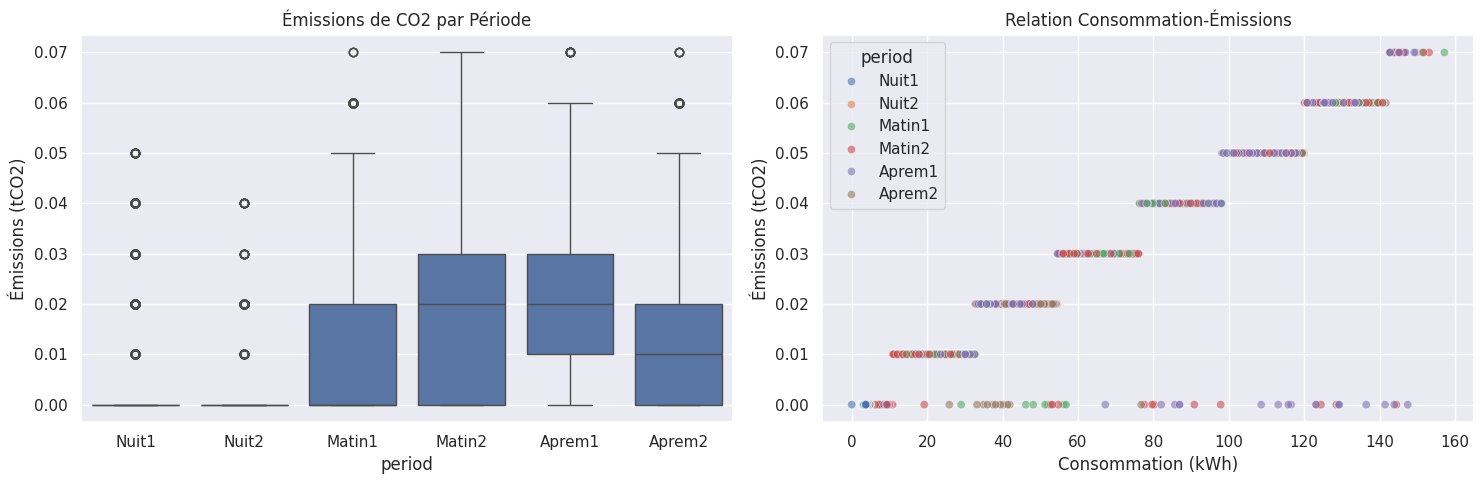

Variance expliquée par composante :
PC1: 0.566 (0.566 cumulé)
PC2: 0.357 (0.923 cumulé)
PC3: 0.053 (0.976 cumulé)
PC4: 0.014 (0.990 cumulé)
PC5: 0.008 (0.998 cumulé)
PC6: 0.002 (1.000 cumulé)


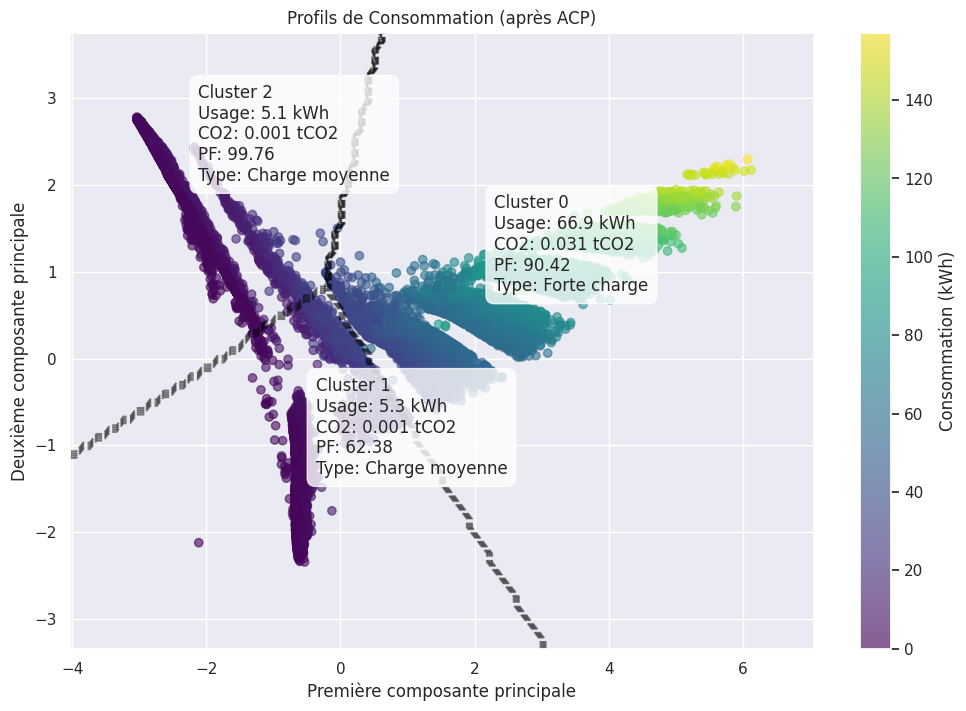


Analyse détaillée des clusters :

Cluster 0:
Nombre de points: 12590
Consommation moyenne: 66.9 kWh
Émissions moyennes: 0.031 tCO2
Facteur de puissance moyen: 90.42
Période dominante: Aprem1

Cluster 1:
Nombre de points: 14836
Consommation moyenne: 5.3 kWh
Émissions moyennes: 0.001 tCO2
Facteur de puissance moyen: 62.38
Période dominante: Nuit2

Cluster 2:
Nombre de points: 7614
Consommation moyenne: 5.1 kWh
Émissions moyennes: 0.001 tCO2
Facteur de puissance moyen: 99.76
Période dominante: Aprem2


In [3]:
# Visualisation des émissions
plt.figure(figsize=(15, 5))

# Distribution temporelle des émissions
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='period', y='CO2(tCO2)')
plt.title('Émissions de CO2 par Période')
plt.ylabel('Émissions (tCO2)')

# Relation consommation-émissions
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='Usage_kWh', y='CO2(tCO2)',
                hue='period', alpha=0.6)
plt.title('Relation Consommation-Émissions')
plt.xlabel('Consommation (kWh)')
plt.ylabel('Émissions (tCO2)')

plt.tight_layout()
# /!\ Complétez les '...' pour afficher la figure /!\
plt.show()

# %% [code]
# Sélection des features pertinentes pour l'analyse environnementale
features = [
    'Usage_kWh',
    'CO2(tCO2)',
    'Lagging_Current_Reactive.Power_kVarh',
    'Leading_Current_Reactive_Power_kVarh',
    'Lagging_Current_Power_Factor',
    'Leading_Current_Power_Factor'
]

# Standardisation
scaler = StandardScaler()
X = scaler.fit_transform(df[features])

# ACP
pca = PCA()
X_pca = pca.fit_transform(X)

# Affichage de la variance expliquée
explained_variance_ratio = pca.explained_variance_ratio_
cumsum_variance_ratio = np.cumsum(explained_variance_ratio)

print("Variance expliquée par composante :")
for i, var in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {var:.3f} ({cumsum_variance_ratio[i]:.3f} cumulé)")

# Sélection des 2 premières composantes pour le clustering
X_pca_2d = X_pca[:, :2]

# K-means sur les composantes principales
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_pca_2d)

# Visualisation
plt.figure(figsize=(12, 8))

# Création de la grille pour les frontières
x_min, x_max = X_pca_2d[:, 0].min() - 1, X_pca_2d[:, 0].max() + 1
y_min, y_max = X_pca_2d[:, 1].min() - 1, X_pca_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Frontières des clusters
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='black', linestyles='--', alpha=0.5)

# Scatter plot
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                     c=df['Usage_kWh'],  # Coloration selon la consommation
                     cmap='viridis',
                     alpha=0.6)

# Annotations des clusters
for i in range(3):
    cluster_data = df[df['Cluster'] == i]
    centroid = X_pca_2d[df['Cluster'] == i].mean(axis=0)

    # Caractéristiques du cluster
    usage_mean = cluster_data['Usage_kWh'].mean()
    co2_mean = cluster_data['CO2(tCO2)'].mean()
    pf_mean = cluster_data['Lagging_Current_Power_Factor'].mean()

    # Détermination du type de profil
    if usage_mean > df['Usage_kWh'].quantile(0.66):
        profile = "Forte charge"
    elif usage_mean > df['Usage_kWh'].quantile(0.33):
        profile = "Charge moyenne"
    else:
        profile = "Faible charge"

    plt.annotate(
        f'Cluster {i}\n'
        f'Usage: {usage_mean:.1f} kWh\n'
        f'CO2: {co2_mean:.3f} tCO2\n'
        f'PF: {pf_mean:.2f}\n'
        f'Type: {profile}',
        xy=(centroid[0], centroid[1]),
        xytext=(10, 10),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8)
    )

plt.title('Profils de Consommation (après ACP)')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.colorbar(scatter, label='Consommation (kWh)')
plt.grid(True)
plt.show()

# Analyse des clusters
print("\nAnalyse détaillée des clusters :")
for i in range(3):
    cluster_data = df[df['Cluster'] == i]
    print(f"\nCluster {i}:")
    print(f"Nombre de points: {len(cluster_data)}")
    print(f"Consommation moyenne: {cluster_data['Usage_kWh'].mean():.1f} kWh")
    print(f"Émissions moyennes: {cluster_data['CO2(tCO2)'].mean():.3f} tCO2")
    print(f"Facteur de puissance moyen: {cluster_data['Lagging_Current_Power_Factor'].mean():.2f}")
    print(f"Période dominante: {cluster_data['period'].value_counts().index[0]}")


❓ Questions d'Analyse :

1. **Patterns d'Émissions**
   - Quelles périodes montrent les émissions les plus élevées ?
   - Comment expliquer les variations d'émission carbone ?
   - Quel(s) facteur(s) influence(nt) le plus ces émissions ?

2. **Pistes d'Amélioration**
   - Quelles actions concrètes peuvent être proposées pour réduire l'empreinte carbone ?

## Analyse des Clusters et Recommandations

### 1. Identification des Profils

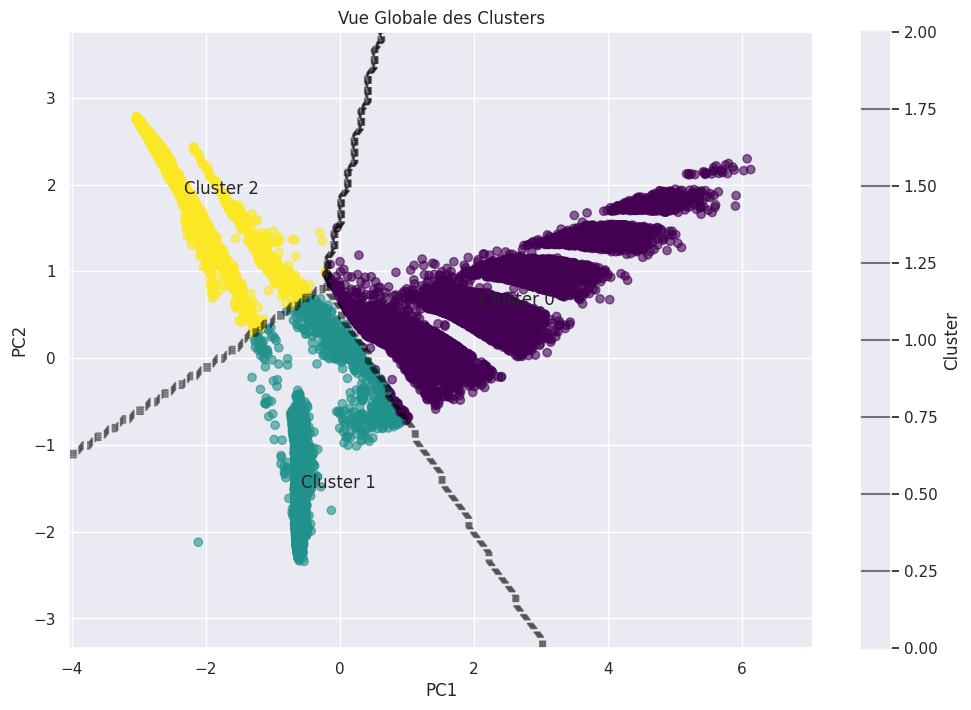

In [4]:
# Visualisation principale des clusters avec leurs caractéristiques
plt.figure(figsize=(12, 8))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
           c=df['Cluster'], cmap='viridis',
           alpha=0.6)
plt.contour(xx, yy, Z, colors='black', linestyles='--', alpha=0.5)

for i in range(3):
    cluster_data = df[df['Cluster'] == i]
    centroid = X_pca_2d[df['Cluster'] == i].mean(axis=0)
    plt.annotate(f'Cluster {i}', xy=(centroid[0], centroid[1]))

plt.title('Vue Globale des Clusters')
# /!\ Complétez les '...' pour nommer l'axe des abscisses PC1 et l'axe des ordonnées PC2 /!\
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.colorbar(label='Cluster')
plt.show()

❓ Questions sur la séparation des clusters :
- Que représente la distance entre les points d'un même cluster ?
- Comment expliquer la forme allongée du cluster 0 ?

### 2. Analyse du Cluster 1 - Problème d'Efficience Nocturne


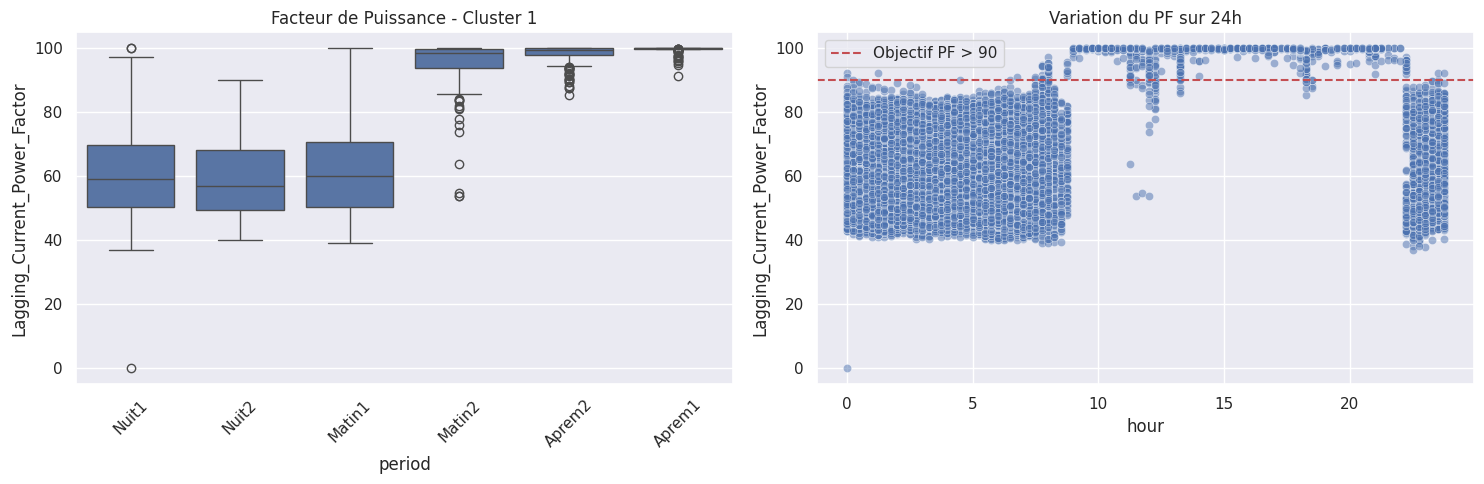

Statistiques Cluster 1 par période:
         count       mean        std    min     25%     50%       75%     max
period                                                                       
Aprem1   253.0  99.749881   0.884398  91.43  99.910  99.980  100.0000  100.00
Aprem2   307.0  98.362801   2.546057  85.54  97.805  99.520  100.0000  100.00
Matin1  3578.0  61.573446  12.913117  39.19  50.520  60.070   70.7100  100.00
Matin2   265.0  95.628491   6.912018  53.69  93.930  98.470   99.9400  100.00
Nuit1   4764.0  60.654731  11.839649   0.00  50.300  59.095   69.7725  100.00
Nuit2   5669.0  59.163217  11.281321  40.15  49.450  57.000   68.2700   90.22


In [5]:
# Visualisation de l'efficience par période
cluster1_data = df[df['Cluster'] == 1]

plt.figure(figsize=(15, 5))

# Distribution du facteur de puissance par période
plt.subplot(1, 2, 1)
sns.boxplot(data=cluster1_data, x='period',
            y='Lagging_Current_Power_Factor')
# /!\ Complétez les '...' pour ajouter le titre à la figure : Facteur de Puissance - Cluster 1  /!\
plt.title('Facteur de Puissance - Cluster 1')

plt.xticks(rotation=45)

# Évolution temporelle
plt.subplot(1, 2, 2)
sns.scatterplot(data=cluster1_data,
                x='hour',
                y='Lagging_Current_Power_Factor',
                alpha=0.5)
plt.axhline(y=90, color='r', linestyle='--',
            label='Objectif PF > 90')
plt.title('Variation du PF sur 24h')
plt.legend()
plt.tight_layout()
plt.show()

print("Statistiques Cluster 1 par période:")
print(cluster1_data.groupby('period')['Lagging_Current_Power_Factor'].describe())

❓ Questions sur l'inefficience nocturne :
- Pourquoi le facteur de puissance est-il plus faible la nuit ?
- Quel serait l'impact financier d'une amélioration du PF nocturne ?

### 3. Analyse du Cluster 0 - Gestion des Pics de Charge


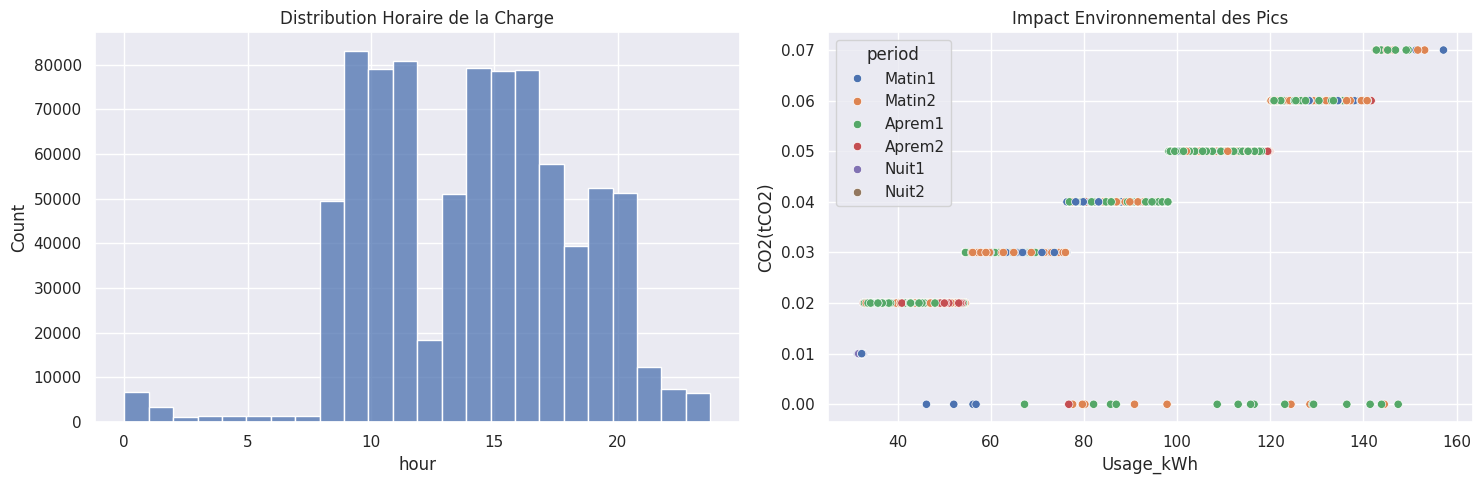


Analyse des pics par période:
             mean  count
period                  
Aprem1  69.269565   4249
Matin2  68.913761   3321
Matin1  68.321719   1978
Aprem2  61.693536   2520
Nuit1   58.006959    411
Nuit2   45.874414    111


In [6]:
# Analyse des pics de consommation
# /!\ Complétez les '...' affecter à la variable cluster0_data le dataframe où uniquement le cluster 0 est sélectionné /!\
cluster0_data = df[df['Cluster'] == 0]

plt.figure(figsize=(15, 5))

# Distribution horaire de la charge
plt.subplot(1, 2, 1)
sns.histplot(data=cluster0_data, x='hour',
             weights='Usage_kWh', bins=24)
plt.title('Distribution Horaire de la Charge')

# Relation charge-émissions
plt.subplot(1, 2, 2)
sns.scatterplot(data=cluster0_data,
                x='Usage_kWh',
                y='CO2(tCO2)',
                hue='period')
plt.title('Impact Environnemental des Pics')
plt.tight_layout()
plt.show()

# Analyse des périodes de pic
peak_periods = cluster0_data.groupby('period')['Usage_kWh'].agg(['mean', 'count'])
print("\nAnalyse des pics par période:")
print(peak_periods.sort_values('mean', ascending=False))

❓ Questions sur les pics de charge :
- Pourquoi les pics sont-ils concentrés sur certaines périodes ?
- Quel est le compromis entre lissage de charge et contraintes de production ?

### 4. Analyse du Cluster 2 - Modèle d'Efficience


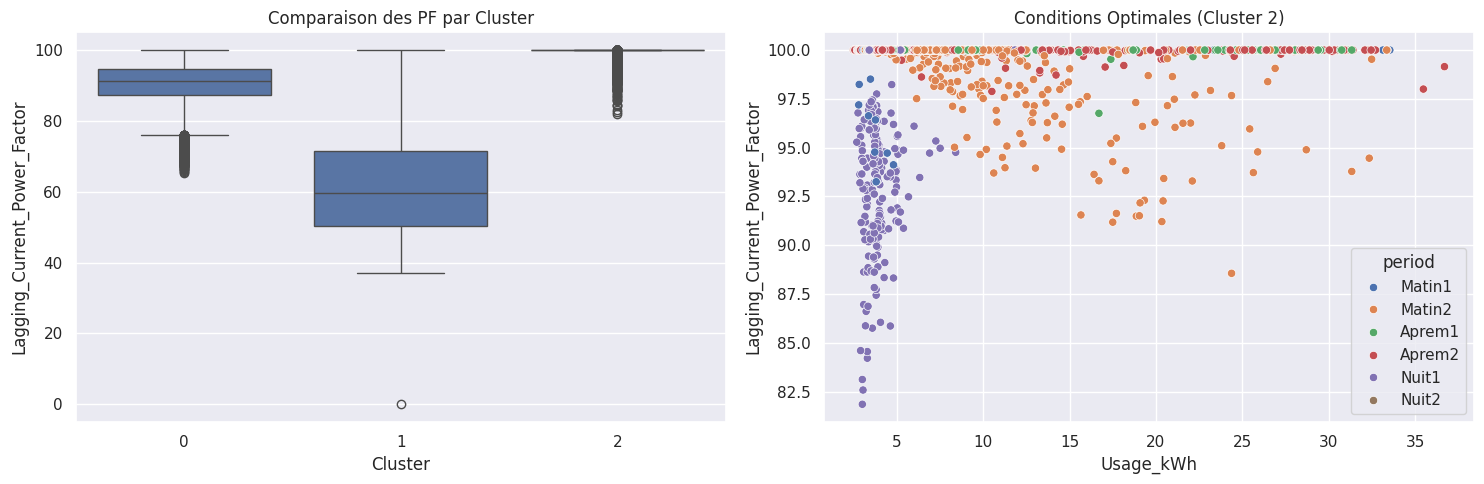


Conditions optimales d'opération:
        Usage_kWh  Lagging_Current_Power_Factor
period                                         
Aprem1       5.13                        100.00
Aprem2       4.81                         99.99
Matin1       4.96                         99.95
Matin2       5.65                         99.90
Nuit1        3.78                         99.63
Nuit2        3.05                        100.00


In [7]:
# Comparaison des conditions opérationnelles
cluster2_data = df[df['Cluster'] == 2]

plt.figure(figsize=(15, 5))

# Comparaison des facteurs de puissance
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Cluster',
            y='Lagging_Current_Power_Factor')
plt.title('Comparaison des PF par Cluster')

# Analyse des conditions optimales
plt.subplot(1, 2, 2)
sns.scatterplot(data=cluster2_data,
                x='Usage_kWh',
                y='Lagging_Current_Power_Factor',
                hue='period')
plt.title('Conditions Optimales (Cluster 2)')
plt.tight_layout()
plt.show()

# Identification des meilleures pratiques
best_conditions = cluster2_data[cluster2_data['Lagging_Current_Power_Factor'] > 95]
print("\nConditions optimales d'opération:")
print(best_conditions.groupby('period').agg({
    'Usage_kWh': 'mean',
    'Lagging_Current_Power_Factor': 'mean'
}).round(2))

❓ Questions sur les bonnes pratiques :
- Quelles conditions spécifiques permettent d'atteindre un PF > 95 ?
- Comment généraliser ces conditions aux autres périodes ?
- Quel serait la conséquence financière de mise en œuvre de ces améliorations ?

### 5. Plan de Mise en Œuvre et Suivi


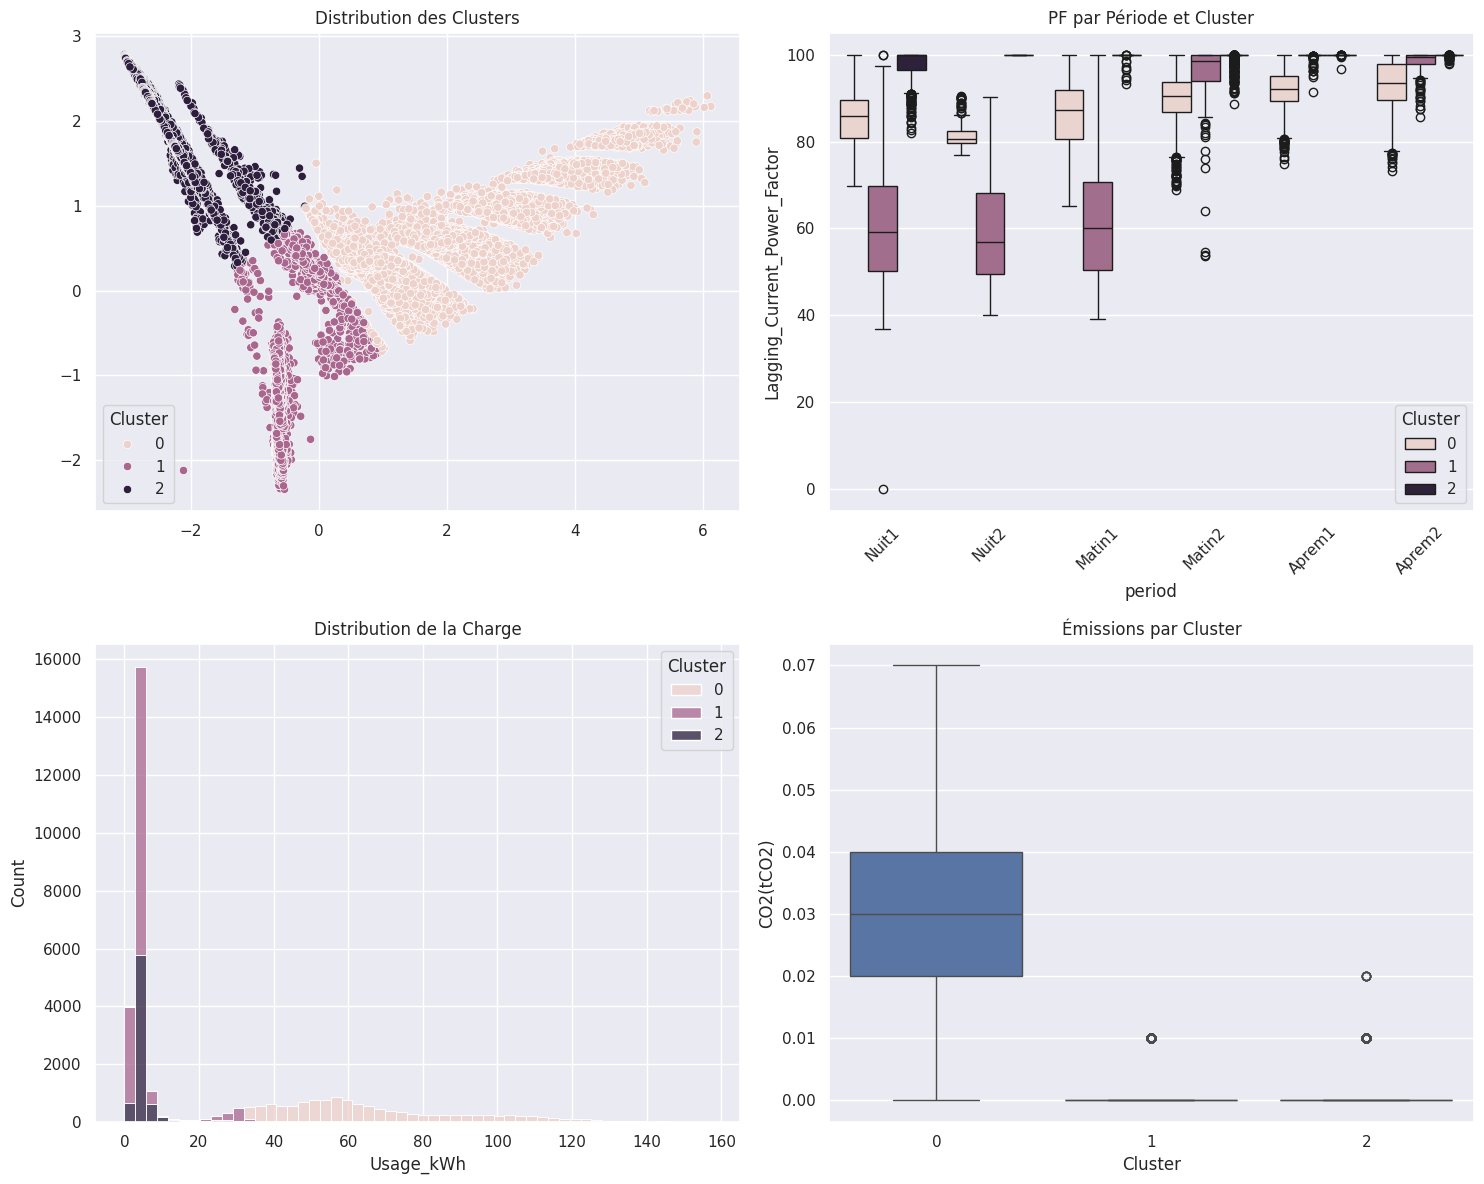


KPIs de Base:

Cluster 0:
PF moyen: 90.42
% points PF > 90: 58.4%
Émissions moyennes: 0.031 tCO2

Cluster 1:
PF moyen: 62.38
% points PF > 90: 6.0%
Émissions moyennes: 0.001 tCO2

Cluster 2:
PF moyen: 99.76
% points PF > 90: 99.6%
Émissions moyennes: 0.001 tCO2


In [8]:
# Création d'un dashboard de suivi
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribution des clusters
sns.scatterplot(data=df, x=X_pca_2d[:, 0], y=X_pca_2d[:, 1],
                hue='Cluster', ax=axes[0, 0])
axes[0, 0].set_title('Distribution des Clusters')

# 2. Évolution du PF
sns.boxplot(data=df, x='period', y='Lagging_Current_Power_Factor',
            hue='Cluster', ax=axes[0, 1])
axes[0, 1].set_title('PF par Période et Cluster')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Distribution de la charge
sns.histplot(data=df, x='Usage_kWh', hue='Cluster',
             multiple="stack", ax=axes[1, 0])
axes[1, 0].set_title('Distribution de la Charge')

# 4. Émissions par cluster
sns.boxplot(data=df, x='Cluster', y='CO2(tCO2)', ax=axes[1, 1])
axes[1, 1].set_title('Émissions par Cluster')

plt.tight_layout()
plt.show()

# KPIs actuels
print("\nKPIs de Base:")
for cluster in range(3):
    cluster_data = df[df['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"PF moyen: {cluster_data['Lagging_Current_Power_Factor'].mean():.2f}")
    print(f"% points PF > 90: {(cluster_data['Lagging_Current_Power_Factor'] > 90).mean()*100:.1f}%")
    print(f"Émissions moyennes: {cluster_data['CO2(tCO2)'].mean():.3f} tCO2")

❓ Questions sur le suivi :
- Quels KPIs additionnels seraient pertinents ?
- Comment détecter une dérive des performances ?

## Recommandations pour la Réduction des Émissions

1. **Optimisation Opérationnelle**
   - Identifier et reproduire les conditions des périodes à faible intensité
   - Optimiser la planification des opérations énergivores
   - Former les équipes aux meilleures pratiques environnementales

2. **Améliorations Techniques**
   - Moderniser les équipements les plus émetteurs
   - Installer des systèmes de monitoring des émissions en temps réel
   - Mettre en place des systèmes de récupération d'énergie

3. **Stratégie Long Terme**
   - Définir des objectifs de réduction par cluster
   - Investir dans des technologies bas-carbone
   - Développer un plan de transition énergétique

❓ Questions sur la mise en œuvre :
- Par où commencer concrètement ?
- Comment impliquer les équipes dans ces changements ?